<a href="https://colab.research.google.com/github/Ahmedzayan1/cassava_leaf_disease_classification/blob/main/cassava_leaf_disease_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle==1.5.12

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.0/59.0 kB 876.2 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73027 sha256=15e7610d755402ac2dc72fe74b47482c586181cda6d2752365ffaeca7e60623c
  Stored in directory: /root/.cache/pip/wheels/70/0c/e6/79103212a102e78b8453691b905f48000219574ba7137e7207
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.6.17
    Uninstalling kaggle-1.6.17:
      Successfully uninstalled kaggle-1.6.17


In [ ]:
from google.colab import files
uploaded = files.upload()


!mkdir -p ~/.kaggle


!cp /content/kaggle.json ~/.kaggle/


!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c cassava-leaf-disease-classification

100% 5.75G/5.76G [01:22<00:00, 87.3MB/s]
100% 5.76G/5.76G [01:22<00:00, 75.1MB/s]


In [ ]:
!unzip /content/cassava-leaf-disease-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/3954487465.jpg  
  inflating: train_images/3954910918.jpg  
  inflating: train_images/3955391972.jpg  
  inflating: train_images/3955442838.jpg  
  inflating: train_images/3955739563.jpg  
  inflating: train_images/3955931830.jpg  
  inflating: train_images/3955972139.jpg  
  inflating: train_images/3956075690.jpg  
  inflating: train_images/3956077728.jpg  
  inflating: train_images/3956155774.jpg  
  inflating: train_images/3956271103.jpg  
  inflating: train_images/3956372146.jpg  
  inflating: train_images/3956407201.jpg  
  inflating: train_images/3956550570.jpg  
  inflating: train_images/3956605397.jpg  
  inflating: train_images/3956778160.jpg  
  inflating: train_images/3957562076.jpg  
  inflating: train_images/3957612771.jpg  
  inflating: train_images/3957807023.jpg  
  inflating: train_images/3957819631.jpg  
  inflating: train_images/395820132.jpg  
  inflating: train_images/3958304403.jpg  
  in

In [ ]:
import pandas as pd
df = pd.read_csv('train.csv')
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


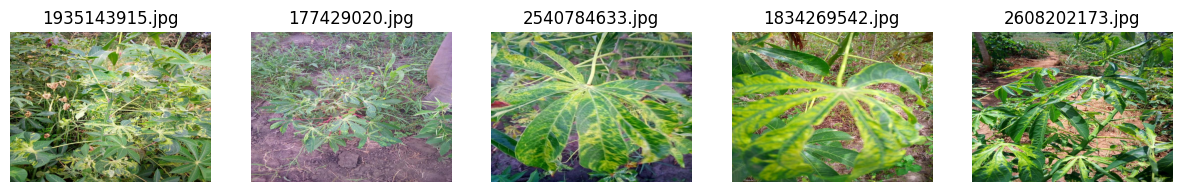

In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

folder_path = '/content/train_images'

image_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

num_samples = 5
plt.figure(figsize=(15, 10))

for i in range(min(num_samples, len(image_files))):
    img_path = os.path.join(folder_path, image_files[i])
    img = Image.open(img_path)
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(img)
    plt.title(image_files[i])
    plt.axis('off')

plt.show()


In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torchvision.models as models

In [ ]:
class CassavaDataset(Dataset):
        def __init__(self, csv_file, image_dir, transform=None):
            self.data = pd.read_csv(csv_file)
            self.image_dir = image_dir
            self.transform = transform

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            image_name = self.data.iloc[idx, 0]
            image_path = os.path.join(self.image_dir, image_name)
            image = Image.open(image_path).convert('RGB')
            label = self.data.iloc[idx, 1]
            if self.transform:
                image = self.transform(image)
            return image, label

In [ ]:
import os
print(os.listdir('test_images'))

['2216849948.jpg']


In [ ]:

data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = CassavaDataset('train.csv', 'train_images', transform=data_transform)
test_dataset = CassavaDataset('/content/sample_submission.csv', '/content/test_images', transform=data_transform)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [ ]:
model = models.efficientnet_b3(pretrained=True)
num_ftrs = model.classifier[1].in_features
model.classifier[1] = torch.nn.Linear(num_ftrs, 5)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 67.6MB/s]


In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
import matplotlib.pyplot as plt


train_losses = []

train_accuracies = []

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

num_epochs = 3
for epoch in range(num_epochs):
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()


        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct_train / total_train

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")





print("Finished Training")


Epoch 1, Train Loss: 0.2690, Train Accuracy: 90.64%
Epoch 2, Train Loss: 0.2149, Train Accuracy: 92.61%
Epoch 3, Train Loss: 0.1684, Train Accuracy: 94.14%
Finished Training


In [ ]:

model = model.to(device)

# Testing loop
model.eval()

correct_test = 0
total_test = 0
running_test_loss = 0.0

with torch.no_grad():
    for data in test_loader:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        running_test_loss += loss.item()

        # Calculate test accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

test_loss = running_test_loss / len(test_loader)
test_accuracy = 100 * correct_test / total_test

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 0.6794, Test Accuracy: 100.00%


In [ ]:
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Training Loss')
    plt.plot(epochs, val_losses, 'ro-', label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracies, 'ro-', label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)
